red wine SVM with Features Selection Alcohol and fixed acidity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
plt.style.use("ggplot")  #using style ggplot
from sklearn.metrics import accuracy_score, confusion_matrix


Load red wine quality Dataset

In [2]:
%matplotlib inline
red_wine = pd.read_csv('../winequality-red.csv', delimiter=';')

<Axes: >

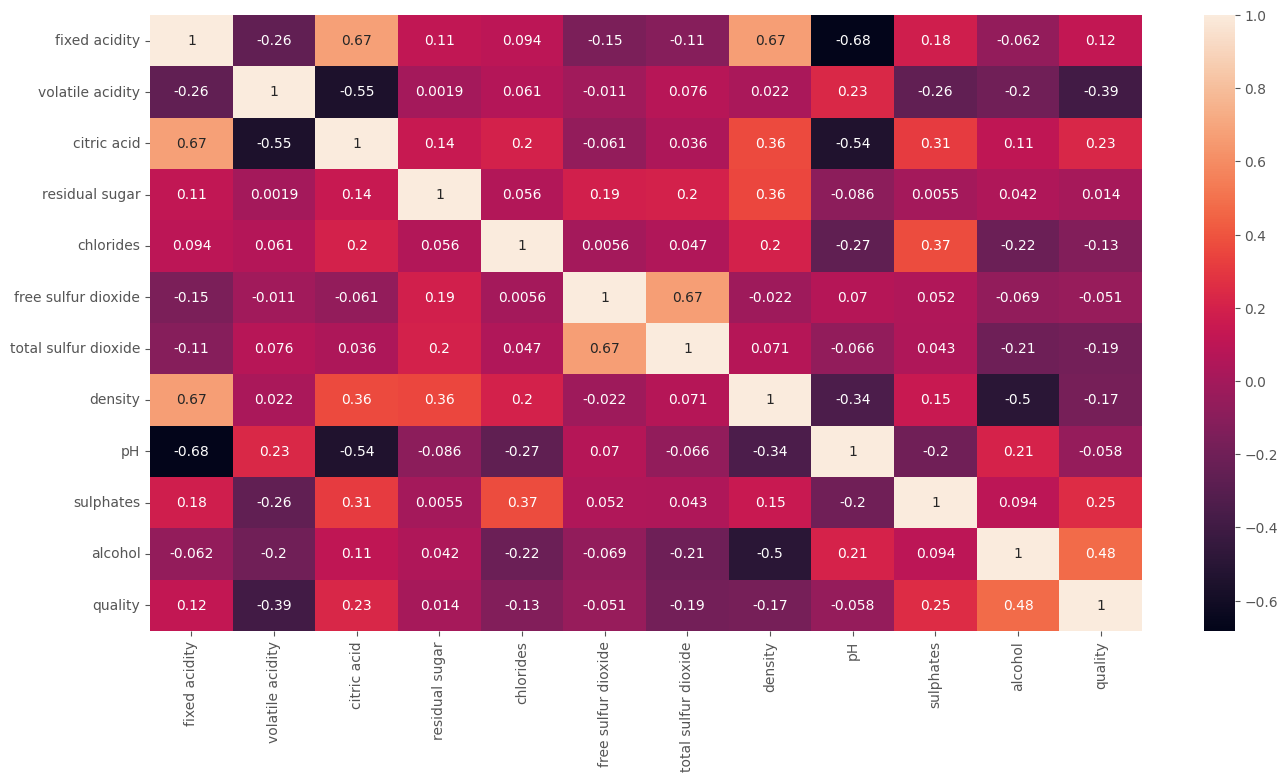

In [3]:
# check correlation among variables
corr = red_wine.corr()

# creat heatmap of correlation
plt.figure(figsize = [16, 8], facecolor = 'white')
sns.heatmap(corr, annot = True)

In [4]:
corr['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

Preprocessing Data for performing SVM algorithms

In [5]:
#Making binary classificaion for the response variable.
#Dividing wine as good and bad by giving the limit for the quality
bins = (2, 5, 8)
group_names = ['0', '1']
red_wine['quality'] = pd.cut(red_wine['quality'], bins = bins, labels = group_names)

In [6]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         1599 non-null   float64 
 1   volatile acidity      1599 non-null   float64 
 2   citric acid           1599 non-null   float64 
 3   residual sugar        1599 non-null   float64 
 4   chlorides             1599 non-null   float64 
 5   free sulfur dioxide   1599 non-null   float64 
 6   total sulfur dioxide  1599 non-null   float64 
 7   density               1599 non-null   float64 
 8   pH                    1599 non-null   float64 
 9   sulphates             1599 non-null   float64 
 10  alcohol               1599 non-null   float64 
 11  quality               1599 non-null   category
dtypes: category(1), float64(11)
memory usage: 139.2 KB


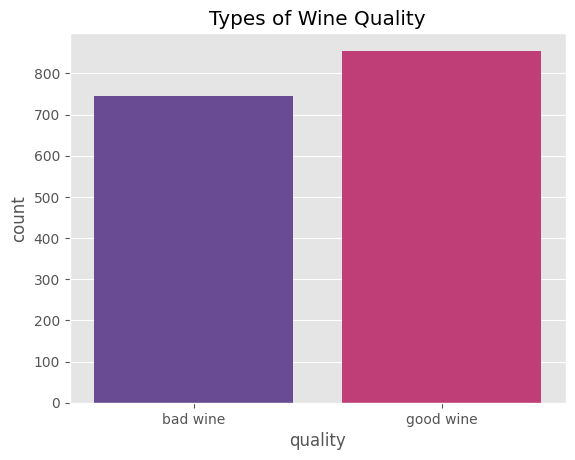

In [7]:
sns.countplot(data = red_wine, x = 'quality', hue = 'quality',palette=['#663f9e',"#d42875"])
plt.xticks([0,1], ['bad wine','good wine'])
plt.title("Types of Wine Quality")

plt.show()

In [8]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000


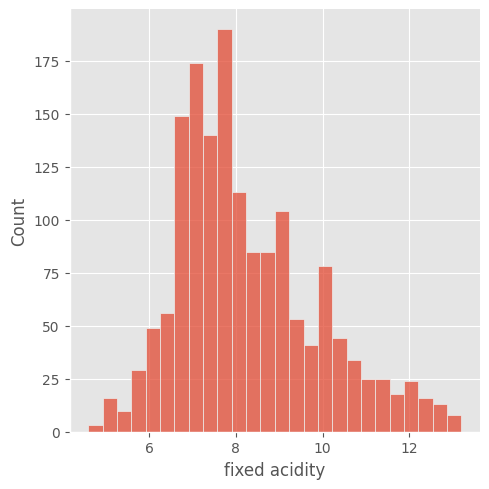

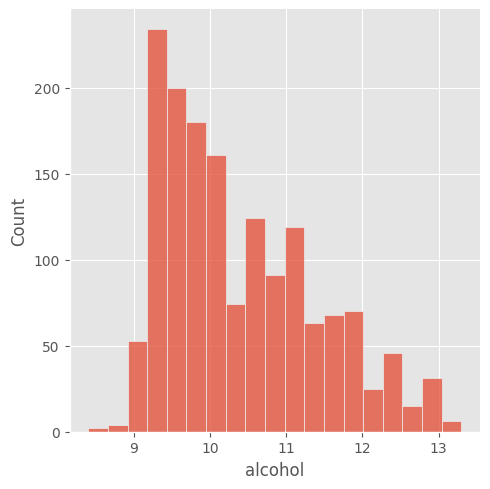

In [9]:
#deal with fixed acidity outliers
q = red_wine['fixed acidity'].quantile(0.99)
red_wine = red_wine[red_wine['fixed acidity'] < q]
sns.displot(red_wine['fixed acidity'])

#deal with alcohol outliers
q = red_wine['alcohol'].quantile(0.99)
red_wine = red_wine[red_wine['alcohol'] < q]
sns.displot(red_wine['alcohol'])

In [10]:
red_wine.columns.values

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'], dtype=object)

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# the target column (in this case 'quality') should not be included in variables
#Categorical variables may or maynot be added if any
variables = red_wine[['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',]]
x = add_constant(variables)
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(x.values,i) for i in range (x.shape[1])]
vif['features'] = x.columns
vif

#Using 10 as the minimum vif values i.e any independent variable 10 and above will have to be dropped
#From the results all independent variable are below 10

,VIF,features
0,1.771651e+06,const
1,7.196469e+00,fixed acidity
2,1.801806e+00,volatile acidity
3,3.110722e+00,citric acid
4,1.710092e+00,residual sugar
5,1.485028e+00,chlorides
6,1.965168e+00,free sulfur dioxide
7,2.227438e+00,total sulfur dioxide
8,5.896027e+00,density
9,3.224563e+00,pH


In [12]:
#convert data type to numeric
red_wine = red_wine.astype('float64')
# Add 'alcohol' and 'fixed acidity' columns from red wine dataset to data_X
data_X = red_wine[['alcohol', 'fixed acidity']]
data_y = red_wine['quality']

print(data_X.shape)
print(data_y.shape)

(1566, 2)
(1566,)


In [13]:
red_wine.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1566 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1566 non-null   float64
 1   volatile acidity      1566 non-null   float64
 2   citric acid           1566 non-null   float64
 3   residual sugar        1566 non-null   float64
 4   chlorides             1566 non-null   float64
 5   free sulfur dioxide   1566 non-null   float64
 6   total sulfur dioxide  1566 non-null   float64
 7   density               1566 non-null   float64
 8   pH                    1566 non-null   float64
 9   sulphates             1566 non-null   float64
 10  alcohol               1566 non-null   float64
 11  quality               1566 non-null   float64
dtypes: float64(12)
memory usage: 159.0 KB


In [14]:
# sns.scatterplot(x=red_wine['volatile acidity'],y=red_wine['fixed acidity'],hue=red_wine['quality'],palette=['#FA7070','#D875C7'])

In [15]:
def train_test_split(X,y,test_size):
    test_size = test_size
    train_size = 1 - float(test_size)
    total_rows = red_wine.shape[0]
    split =  int(total_rows * (train_size))
    X_train = data_X[0:split]
    X_test = data_X[split:]
    y_train = data_y[0:split]
    y_test = data_y[split:]
    return X_train, X_test, y_train, y_test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.2)

In [17]:
print("X train:",len(X_train))
print("X test:",len(X_test))
print("y train:",len(y_train))
print("y test:",len(y_test))

X train: 1252
X test: 314
y train: 1252
y test: 314


In [18]:
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

In [19]:
X_train.shape

(1252, 2)

In [20]:
data_y_counts = y_train.value_counts()
data_y_counts

quality
 1.0    673
-1.0    579
Name: count, dtype: int64

In [21]:
data_y_counts = y_test.value_counts()
data_y_counts

quality
-1.0    159
 1.0    155
Name: count, dtype: int64

In [22]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data (do not fit again!)
X_test_scaled = scaler.transform(X_test)

In [23]:
class SVM:
    def __init__(self, learning_rate, lambda_param, n_iterations):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)  # กำหนดค่าเริ่มต้นของพารามิเตอร์ w เป็นศูนย์
        self.b = 1000

        for _ in range(self.n_iterations): # วนลูปเพื่ออัพเดทพารามิเตอร์ในแต่ละรอบ
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition: #อัพเดทพารามิเตอร์ w ในกรณีที่ตรวจสอบเงื่อนไขแล้วค่าของ Loss Function มากกว่าหรือเท่ากับ 1
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:  # อัพเดทพารามิเตอร์ w และ b ในกรณีที่ตรวจสอบเงื่อนไขแล้วค่าของ Loss Function น้อยกว่า 1
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.learning_rate * y[idx]

    def predict(self, X):
        linear_output = np.dot(X, self.w) - self.b
        return np.sign(linear_output)

In [24]:
svm_model = SVM(learning_rate=0.01,lambda_param=0.0001,n_iterations=1000)
svm_model.fit(X_train_scaled, y_train.to_numpy())

In [25]:
svm_y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(svm_y_pred, y_test)
print('Accuracy Score:', float(accuracy*100),"%")

Accuracy Score: 69.42675159235668 %


In [26]:
# Predict using the trained SVM model
# Map predicted labels back to original labels
svm_y_pred_mapped = np.where(svm_y_pred == 1, "GOOD", "BAD")  # Assuming 1 is mapped to good grade , and -1 is mapped to bad grade

# Print the predicted quality
print("Predicted quality of red wine:" ,svm_y_pred_mapped)
print(len(svm_y_pred_mapped))

Predicted quality of red wine: ['GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'BAD'
 'GOOD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'BAD'
 'BAD' 'GOOD' 'GOOD' 'GOOD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'BAD' 'BAD' 'BAD'
 'GOOD' 'GOOD' 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD'
 'GOOD' 'GOOD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD'
 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'BAD'
 'BAD' 'GOOD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD'
 'GOOD' 'GOOD' 'BAD' 'GOOD' 'BAD' 'GOOD' 'BAD' 'BAD' 'GOOD' 'BAD' 'GOOD'
 'BAD' 'GOOD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD' 'GOOD' 'GOOD'
 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD' 'GOOD' 'GOOD'
 'BAD' 'GOOD' 'BAD' 'BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD' 'BAD' 'GOOD'
 'BAD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD' 'GOOD'
 'GOOD' 'BAD' 'BAD' 'BAD' 'GOOD' 'BAD' 'BAD' 'BAD' 'BAD' 'GOOD' 'GOOD'
 'BAD' 'BAD' 'GOOD' 'GOOD' 'GOOD' 'G

In [27]:
def hinge_loss(y_true, y_pred):
    return np.maximum(0, 1 - y_true * y_pred).mean()

# Calculate the hinge loss for the test data
test_hinge_loss = hinge_loss(y_test.to_numpy(), svm_y_pred)
print("Hinge Loss on Test Data:", test_hinge_loss)

Hinge Loss on Test Data: 0.6114649681528662


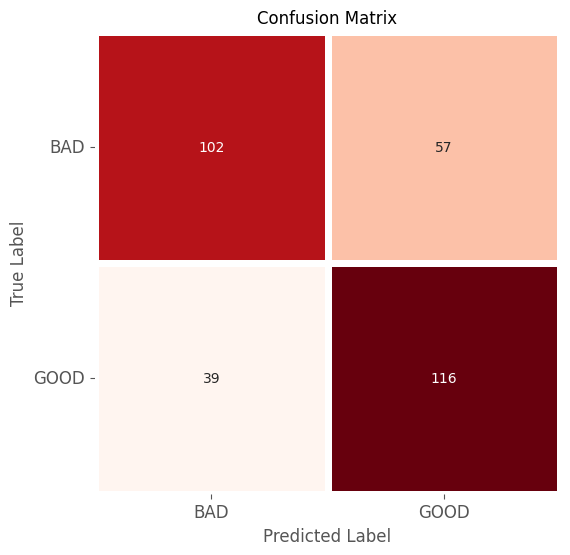

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=svm_y_pred)
df1 = pd.DataFrame(columns=["BAD","GOOD"], index= ["BAD","GOOD"], data= cm )

f,ax = plt.subplots(figsize=(6,6))

sns.heatmap(df1, annot=True,cmap="Reds", fmt= '.0f',ax=ax,linewidths = 5, cbar = False)
plt.xlabel("Predicted Label")
plt.xticks(size = 12)
plt.yticks(size = 12, rotation = 0)
plt.ylabel("True Label")
plt.title("Confusion Matrix", size = 12)
plt.show()

In [29]:
from sklearn.preprocessing import StandardScaler

# ใช้ MinMaxScaler ที่ฝึกไว้กับชุดข้อมูลเดิม
scaler = StandardScaler()

# ทำการ fit ข้อมูลเดิมอีกครั้ง
scaler.fit(data_X)

# สร้างข้อมูลใหม่ที่ต้องการทำนาย
new_redwine = red_wine.sample(5)
new_data_X = new_redwine[['alcohol', 'fixed acidity']]
new_data_y = new_redwine[['quality']]
# Transform ข้อมูลใหม่ด้วย StandardScaler ที่ฝึกไว้กับข้อมูลเดิม
new_data_X_scaled = scaler.transform(new_data_X)

# ทำการทำนายโดยใช้โมเดล SVM ที่ฝึกไว้กับข้อมูลเดิม
svm_y_pred_new = svm_model.predict(new_data_X_scaled)

# Map รหัสคุณภาพที่ทำนายได้เป็นคำอธิบายที่มีความหมาย
svm_y_pred_mapped = np.where(svm_y_pred_new == 1, "GOOD", "BAD")

# แสดงผลคุณภาพที่ทำนายได้
print("Predicted quality of new red wine samples:", svm_y_pred_mapped)

# แสดงผลคุณภาพจริงของไวน์แดงใหม่เพื่อเปรียบเทียบ
print("Actual quality of new red wine samples:" , new_redwine['quality'].values)


Predicted quality of new red wine samples: ['BAD' 'BAD' 'BAD' 'GOOD' 'BAD']
Actual quality of new red wine samples: [ 1. -1. -1.  1. -1.]


In [30]:
def new_hinge_loss(y_true, y_pred):
    return np.maximum(0, 1 - y_true * y_pred).mean()

# Calculate the hinge loss for the test data
new_hinge_loss = hinge_loss(new_data_y.to_numpy(), svm_y_pred_new)
print("Hinge Loss on data prediction:", new_hinge_loss)

Hinge Loss on data prediction: 0.88


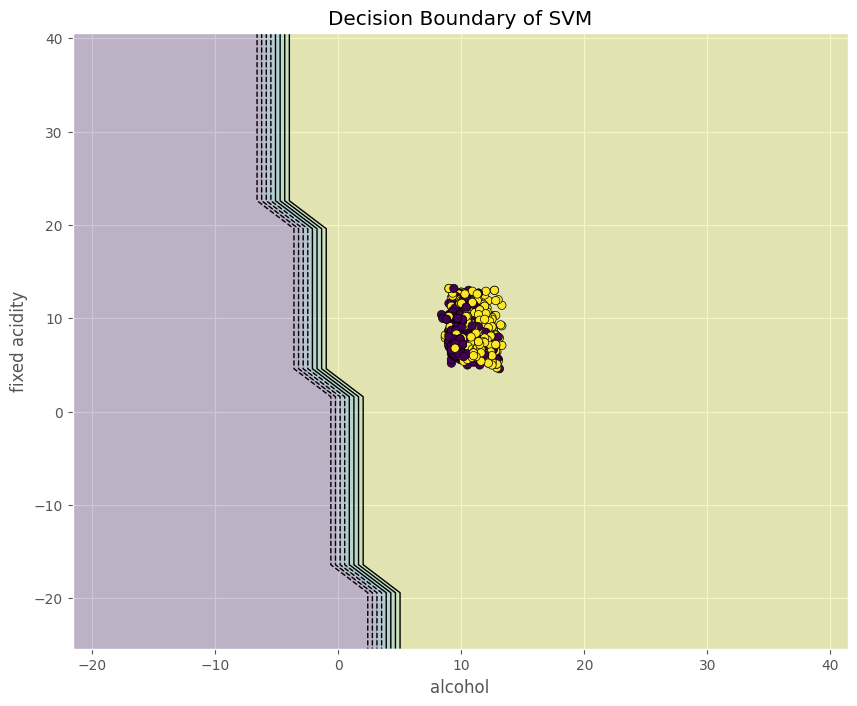

In [31]:
# Define mesh grid
h = 3 # Boundary lines' resolution
x_min, x_max = red_wine['alcohol'].min() - 10*h, red_wine['alcohol'].max() + 10*h
y_min, y_max = red_wine['fixed acidity'].min() - 10*h, red_wine['fixed acidity'].max() + 10*h
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

# Predict the labels for all points in the mesh grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.contourf(xx, yy, Z, alpha=0.25)
plt.contour(xx, yy, Z, colors='k', linewidths=1)
plt.scatter(red_wine['alcohol'], red_wine['fixed acidity'], c=red_wine['quality'], edgecolors='k')
plt.xlabel('alcohol')
plt.ylabel('fixed acidity')
plt.title('Decision Boundary of SVM')
plt.show()
